In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
from models.sfcn import *
from models.resnet import *
from models.inception_resnet_v2 import *
from models.densenet import *
from models.custom_net import *
from models.shallow_net2 import *
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
from models.ranking_loss import *

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = np.array([self.y[idx]]).astype('float16')
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [8]:
def train(model, train_loader, lr, weight_decay, optimizer, sorter='sodeep/weights/best_model_gruc.pth.tar'):
    criterion = rank_difference_loss(sorter)
#     criterion = nn.HuberLoss()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
        
    total_loss, total_mae_loss, total_mse_loss = 0, 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()

        output = model(inputs)
        
        pred = output.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        loss = criterion(output, labels)
        mae_loss = criterion1(output, labels)
        mse_loss = criterion2(output, labels)
        loss.backward()
#         mae_loss.backward()
#         mse_loss.backward()
        
        optimizer.step()
        
        total_loss += loss.data.item()
        total_mae_loss += mae_loss.data.item()
        total_mse_loss += mse_loss.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
        
    return preds, truths, total_loss, total_mae_loss, total_mse_loss
#     return preds, truths, total_mae_loss, total_mse_loss

In [9]:
def valid(model, valid_loader, sorter='sodeep/weights/best_model_gruc.pth.tar'):
    criterion = rank_difference_loss(sorter)
#     criterion = nn.HuberLoss()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    total_loss, total_mae_loss, total_mse_loss = 0, 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            output = model(inputs)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss = criterion(output, labels)
            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
            
            total_loss += loss.data.item()
            total_mae_loss += mae_loss.data.item()
            total_mse_loss += mse_loss.data.item()
        
    return preds, truths, total_loss, total_mae_loss, total_mse_loss
#     return preds, truths, total_mae_loss, total_mse_loss

In [10]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
img_dir = 'img_npy/'
label_dir = 'labels/data_975.csv'

In [11]:
weight_decay = 0.1
lr = 5e-06
epochs = 300
batch_size = 16
test_batch_size = 32
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau
dropout_rate = 0.5
k = 5

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [13]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=True, norm=True)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
# train_set = NeckDataset(X_train, y_train)

# test set & loader
test_set = NeckDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

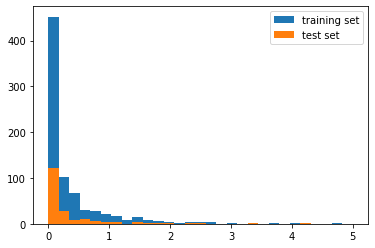

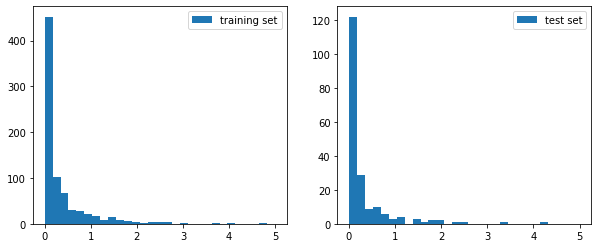

In [14]:
bins = np.linspace(0, 5, 30)

plt.hist(y_train, bins, label='training set')
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')
plt.show()
plt.close()


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_train, bins, label='training set')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')

plt.show()
plt.close()

In [15]:
set_seed()

model = SFCN(dropout_p=dropout_rate)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230214-validation',
           config={"model": "sfcn+lkrelu", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='max', patience=5, min_lr=1e-06)

best_r, best_mae, best_mse = 100, 100, 100

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, rloss_t, mae_t, mse_t = train(model, train_loader, lr, weight_decay, optimizer)
    preds_v, truths_v, rloss_v, mae_v, mse_v = valid(model, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)
    train_rloss = rloss_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)
    valid_rloss = rloss_v / len(test_loader)
    
    scheduler.step(valid_s)
    last_lr = scheduler._last_lr[0]

    if best_r > valid_rloss:
        best_r = valid_rloss
        torch.save(model.state_dict(), 'pretrained/230303_sfcnlkrelu+rloss_{}_bestr'.format(sched_class.__name__))
    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230303_sfcnlkrelu+rloss_{}_bestmse'.format(sched_class.__name__))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230303_sfcnlkrelu+rloss_{}_bestmae'.format(sched_class.__name__))

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr, "train_rloss": train_rloss, "valid_rloss": valid_rloss})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230303_sfcnlkrelu+rloss_{}_epochs{}'.format(sched_class.__name__, epochs))


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 2 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


# Epoch 3 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 4 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.29it/s]


# Epoch 5 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 6 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


# Epoch 7 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 8 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.33it/s]


# Epoch 9 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


# Epoch 10 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


# Epoch 11 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 12 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 13 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 14 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 15 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.17it/s]


# Epoch 16 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.27it/s]


# Epoch 17 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 18 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 19 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 20 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 21 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.24it/s]


# Epoch 22 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 23 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 24 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.24it/s]


# Epoch 25 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 26 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 27 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 28 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


# Epoch 29 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 30 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.26it/s]


# Epoch 31 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 32 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 33 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 34 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.29it/s]


# Epoch 35 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


# Epoch 36 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 37 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.29it/s]


# Epoch 38 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 39 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 40 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 41 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 42 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


# Epoch 43 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 44 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 45 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 46 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 47 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.27it/s]


# Epoch 48 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 49 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.26it/s]


# Epoch 50 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 51 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


# Epoch 52 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 53 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.24it/s]


# Epoch 54 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 55 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 56 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 57 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 58 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 59 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 60 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 61 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 62 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 63 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 64 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.23it/s]


# Epoch 65 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 66 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 67 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 68 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 69 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 70 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 71 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 72 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 73 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


# Epoch 74 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 75 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


# Epoch 76 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 77 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 78 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 79 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 80 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


# Epoch 81 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 82 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 83 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 84 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 85 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 86 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 87 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 88 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 89 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 90 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 91 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.23it/s]


# Epoch 92 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.62it/s]


# Epoch 93 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 94 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 95 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


# Epoch 96 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.54it/s]


# Epoch 97 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


# Epoch 98 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 99 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


# Epoch 100 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 101 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 102 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 103 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 104 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 105 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.33it/s]


# Epoch 106 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 107 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 108 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 109 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 110 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.30it/s]


# Epoch 111 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


# Epoch 112 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 113 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 114 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.24it/s]


# Epoch 115 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


# Epoch 116 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


# Epoch 117 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


# Epoch 118 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 119 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 120 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 121 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 122 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 123 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 124 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


# Epoch 125 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


# Epoch 126 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


# Epoch 127 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 128 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


# Epoch 129 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 130 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.60it/s]


# Epoch 131 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 132 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


# Epoch 133 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


# Epoch 134 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 135 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 136 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 137 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 138 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 139 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 140 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


# Epoch 141 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.58it/s]


# Epoch 142 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 143 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 144 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 145 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 146 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 147 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 148 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.54it/s]


# Epoch 149 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 150 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.58it/s]


# Epoch 151 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


# Epoch 152 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.22it/s]


# Epoch 153 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 154 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 155 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.65it/s]


# Epoch 156 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 157 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.55it/s]


# Epoch 158 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 159 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.64it/s]


# Epoch 160 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 161 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.61it/s]


# Epoch 162 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


# Epoch 163 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 164 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 165 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


# Epoch 166 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.63it/s]


# Epoch 167 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 168 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 169 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 170 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


# Epoch 171 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.62it/s]


# Epoch 172 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 173 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 174 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 175 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 176 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


# Epoch 177 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 178 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


# Epoch 179 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 180 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


# Epoch 181 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 182 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 183 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 184 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 185 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.27it/s]


# Epoch 186 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 187 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 188 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


# Epoch 189 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 190 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 191 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 192 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 193 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.26it/s]


# Epoch 194 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.58it/s]


# Epoch 195 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 196 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]


# Epoch 197 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 198 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 199 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 200 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.61it/s]


# Epoch 201 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 202 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 203 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 204 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 205 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 206 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 207 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.62it/s]


# Epoch 208 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


# Epoch 209 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 210 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.57it/s]


# Epoch 211 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 212 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 213 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 214 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


# Epoch 215 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 216 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 217 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 218 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 219 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 220 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 221 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 222 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


# Epoch 223 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


# Epoch 224 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.59it/s]


# Epoch 225 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


# Epoch 226 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 227 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.33it/s]


# Epoch 228 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 229 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.63it/s]


# Epoch 230 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


# Epoch 231 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


# Epoch 232 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 233 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.27it/s]


# Epoch 234 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 235 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 236 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 237 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 238 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.54it/s]


# Epoch 239 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.30it/s]


# Epoch 240 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 241 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 242 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 243 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 244 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 245 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.61it/s]


# Epoch 246 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


# Epoch 247 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 248 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


# Epoch 249 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 250 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 251 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 252 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


# Epoch 253 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 254 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.59it/s]


# Epoch 255 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 256 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.55it/s]


# Epoch 257 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 258 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 259 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]


# Epoch 260 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


# Epoch 261 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 262 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 263 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 264 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 265 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 266 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.58it/s]


# Epoch 267 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 268 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


# Epoch 269 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 270 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.64it/s]


# Epoch 271 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


# Epoch 272 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 273 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.62it/s]


# Epoch 274 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


# Epoch 275 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 276 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 277 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


# Epoch 278 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


# Epoch 279 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 280 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.24it/s]


# Epoch 281 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


# Epoch 282 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 283 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


# Epoch 284 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 285 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


# Epoch 286 / 300


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


# Epoch 287 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.59it/s]


# Epoch 288 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 289 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


# Epoch 290 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.57it/s]


# Epoch 291 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


# Epoch 292 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


# Epoch 293 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 294 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


# Epoch 295 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 296 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


# Epoch 297 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]


# Epoch 298 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


# Epoch 299 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]


# Epoch 300 / 300


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


lr,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,██▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁
train_mse,██▇▇▇▇▆▆▅▅▄▅▅▅▄▃▃▃▃▃▃▃▄▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▁
train_pearson,▁▁▂▃▃▃▅▄▅▅▆▆▅▅▆▇▆▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇██
train_rloss,▆▇█▆▆▆▅█▄▆▅▇▅▆▄▅▅▄▄▅▅▄▅▅▃▄▃▂▁▄▅▃▅▅▄▄▃▄▃▃
train_spearman,▁▂▃▆▅▅▆▆▅▇▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇██████▇█▇█████
valid_mae,██▇▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▂▁▃▃▃▁▁▂▂▂▃▁▂▂▁▂▂
valid_mse,███▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▄▃▃▃▃▂▃▃▃▂▂▂▂▂▃▁▃▃▁▂▃
valid_pearson,▄▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████████████
valid_rloss,█▄▆▃▂▄▅▃▃▄▅▄▄▇▇▄▄▄▄▂▅▄▃▅▃▄▄▂▄▁▂▄▃▃▄▅▄▄▁▃
valid_spearman,▁▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇█▇▇██████████████████


In [16]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min
    _max = y_max
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [21]:
y_min, y_max =y_test.min() - 0.5, y_test.max() + 0.5
y_min, y_max

(-0.5, 4.701782967868128)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


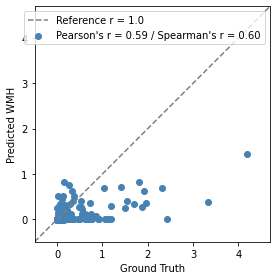

In [22]:
_,_ = predict(model, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


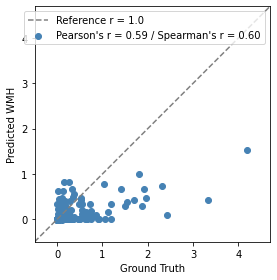

In [23]:
net = SFCN()
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230303_sfcnlkrelu+rloss_{}_bestr'.format(sched_class.__name__)))
net.to(device)
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.60it/s]


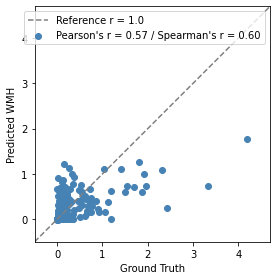

In [24]:
net = SFCN()
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230303_sfcnlkrelu+rloss_{}_bestmse'.format(sched_class.__name__)))
net.to(device)
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


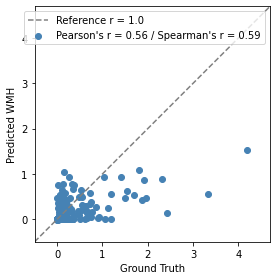

In [25]:
net = SFCN()
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230303_sfcnlkrelu+rloss_{}_bestmae'.format(sched_class.__name__)))
net.to(device)
_,_ = predict(net, test_loader)

In [ ]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, train_loader, 'Training set')